### An analysis of Stack Overflow Developer Survey 2019

Gyorgy Attila Ruzicska

Scientific Python 2020 - Final Project

***

**Summary of analysis**

In this project, I use the 2019 Developer Survey collected by Stack Overflow to analyze a number of interesting questions about the IT profession. The objective of this notebook is to provide a descriptive analysis on socially important questions in the population of the fast-growing IT industry/community. In particular, I am looking to answer three main questions: what are the most popular programming languages; what factors explain career satisfaction; and whether transgender people have more pessimistic views about the future. My analysis is far from being conclusive given the limited background information provided by the users, nonetheless, it can serve as a basis to reveal basic statistical patterns.

Some of my main conclusions are as follows. The most widely used and desired to learn programming language is JavaScript. However, Python is the second most desired language to learn and is mostly studied by those who are not currently working as a developer by profession. Secondly, I show that when predicting career satisfaction, the ability to work remotely is one of the most economically significant positive determinant. On the other hand, the effect of not having had a job previously (probably students) and working in a toxic environment (by self-declaration) are the most significant factors that deteriorate career satisfaction. I also reveal that the proportion of transgender people in the sample of survey respondents is higher than in the overall population, and that they have more optimistic views on the future than an average respondent. Finally, I show that LGBT people are less ambitious to take on manager roles which may raise important policy considerations.

**The data pipeline**

I have downloaded the publicly available, anonymized data from the Stack overflow website: https://insights.stackoverflow.com/survey. The survey consists of two main datasets: survey_results_public.csv and survey_results_schema.csv. The former contains the main dataset where observations are respondents and columns are abbreviations of different questions (mostly multiple choice), while the latter contains the full-text questions corresponding to each abbreviation. (My Appendix also shows these questions for the columns being used in this analysis) Respondents were recruited online and the dataset is more representative among regular Stack Overflow users.

To analyse the data, I cleaned the dataset in multiple steps. These steps are explained below in markdown cells and docstrings.
***

### Data Preparation

Firstly, I import and clean the data so that it can be readily utilized for my analyses.

In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

In [272]:
# Import data
df = pd.read_csv('./developer_survey_2019/survey_results_public.csv')

# Perform some initial exploration of the data characteristics
# df.head()
# print(df.shape)
# df.describe()

In [273]:
#Keep the relevant data for analysis
#This is a subjectice selection of characteristics that I found important to keep
df=df[['MainBranch', 'Hobbyist', 'EdLevel', 'UndergradMajor', 'EduOther', 'DevType',
      'CareerSat', 'LastHireDate', 'JobFactors', 'ConvertedComp', 'WorkWeekHrs', 'MgrWant',
      'WorkPlan', 'WorkChallenge', 'WorkRemote', 'LanguageWorkedWith', 'LanguageDesireNextYear',
      'BetterLife', 'SOVisit1st', 'SOVisitFreq', 'Age', 'Gender', 'Trans', 'Sexuality']]

There are a number of columns in which respondents could choose from multiple options. I create separate columns for each option and indicate whether respondent has selected or not by a dummy variable. Furthermore, I create a function that performs the necessary steps for prediction.

In [274]:
def get_columns(df, multiple_choice_columns):
    '''
    Input:
    df - data frame containing the data
    multiple_choice_columns - list of columns that are multiple choice questions
    
    Output:
    df_clean - dataset in which multiple_choice_columns are removed and separate columns with dummy
               indicating whether selected or not are added
    
    The function performs the following steps:
    1. Generates new columns with zero values based on the set of values present in the multiple
       choice columns
    2. Changes the values to one for those option that are selected by each user
    3. Removes original mutliple choice columns
    
    '''
    
    #Generate the new columns with zeros
    for i in multiple_choice_columns:
        column=df[i]
        list_of_values=[]
        for row in column:
            row=str(row)
            list_of_values.extend(row.split(';'))
        list_of_unique_values=set(list_of_values)
        for j in list_of_unique_values:
            df[i+'_'+j]=0
    
    #Change value if user selected a particular option
    for index, row in df.iterrows():
        for i in multiple_choice_columns:
            row_str=str(row[i])
            list_of_values=row_str.split(';')
            for j in list_of_values:
                df.at[index,i+'_'+j]=1
    
    #Drop original columns
    df=df.drop(multiple_choice_columns, axis=1)
    
    return df

def dummy_numeric_generator(df, to_numeric_columns, dependent_var=None):
    '''
    INPUT
    df - data frame to be cleaned
    to_numeric_columns - dictionary where keys are the column names and values are dictionaries with
                         {...,category[i]: numeric[i],... } as {...,key[i]: value[i],...} pairs
    dependent_var - variable which is to be predicted in the analysis (optional)
    
    OUTPUT
    df - cleaned dataframe
    
    The function performs the following steps:
    1. Drops the rows that lacks the dependent variable (e.g. career satisfaction) when provided
    2. Transform to_numeric_columns to numeric
    5. For all numeric explanatory columns, it fills the NaN values with the mean of columns
    6. Createss dummy variables from categorical variables and sets 'NaN' as base category where possible,
       sets a random category as base where not possible, and drops the base category columns
    '''
    # Drop rows with missing dependent variable
    if dependent_var!=None:
        df = df.dropna(subset=[dependent_var], axis=0)
    
    # Transform categorical columns to numeric
    for k,v in to_numeric_columns.items():
        df=df.replace({k: v})
    
    # Replace NaN values with mean
    numeric_columns = df.select_dtypes(include=['float', 'int']).columns
    for i in numeric_columns:
        df[i].fillna((df[i].mean()), inplace=True)
        
    # Create dummies from categorical variables with nan values
    categorical_columns = df.select_dtypes(include=['object'])
    categorical_nan_columns=categorical_columns.columns[df[df.select_dtypes(include=['object']).columns].isnull().any()]
    categorical_full_columns=categorical_columns.columns[~df[df.select_dtypes(include=['object']).columns].isnull().any()]

    for i in  categorical_nan_columns:
        df = pd.concat([df.drop(i, axis=1), pd.get_dummies(df[i], prefix=i)], axis=1)
    
    # Drop dummy columns that represent nan values to serve as base category in regression
    df = df[df.columns.drop(list(df.filter(regex='_nan', axis=1)))]
    
    # Create dummies from categorical variables with no nan values, drop first categories from each
    for i in  categorical_full_columns:
        df = pd.concat([df.drop(i, axis=1), pd.get_dummies(df[i], prefix=i, drop_first=True)], axis=1) 
    
    return df

In [275]:
multiple_choice_columns=['EduOther', 'DevType', 'JobFactors', 'WorkChallenge', 'LanguageWorkedWith', 'LanguageDesireNextYear', 'Gender', 'Sexuality']
df=get_columns(df, multiple_choice_columns)

***

### Question 1: What are the most popular programming languages?

For the first question, I was interested in checking what are the most widely used programming languages and whether people in different positions use different languages. As we can see from the graphs below, JavaScript is both the most commonly used and the most desired language to learn. There is a huge difference between the proportion of users ever used JavaScript and Python: more than 60% of respondents use the former while only around 40% uses the latter. However, it is interesting to see that while Python is only the 4th most commonly used language, it is the second most desired language to learn.

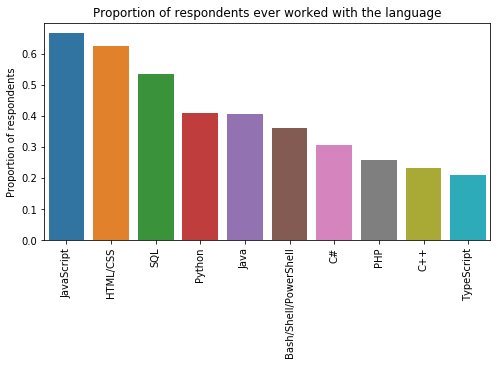

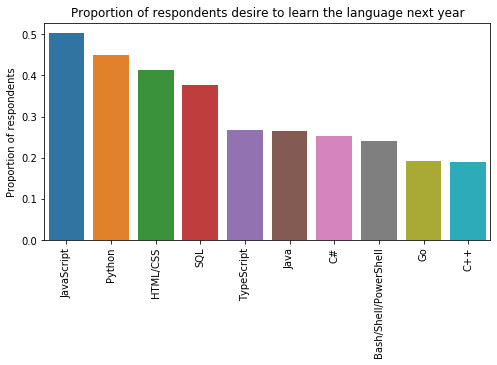

In [276]:
#Firstly, obtain proportion of people worked with and want to learn a given language (top 10)
column_beginnings=['LanguageWorkedWith', 'LanguageDesireNextYear']

for j in range(2):
    globals()[column_beginnings[j]]={i.replace(column_beginnings[j]+'_',''):df[i].mean() for i in df.columns if column_beginnings[j] in i}
    globals()[column_beginnings[j]]={k: [v] for k, v in sorted(globals()[column_beginnings[j]].items(), key=lambda item: item[1], reverse=True)[:10]}
    globals()[column_beginnings[j]]=pd.DataFrame.from_dict(globals()[column_beginnings[j]])
    
#Second, visualize the top 10 programming languages
for i in range(2):
    plt.figure(figsize=(8,4))
    globals()['chart'+str(i)]=sns.barplot(data=globals()[column_beginnings[i]])
    globals()['chart'+str(i)].set_xticklabels(globals()['chart'+str(i)].get_xticklabels(), rotation=90)
    if i==0:
        plt.title('Proportion of respondents ever worked with the language')
        plt.ylabel('Proportion of respondents')
    else:
        plt.title('Proportion of respondents desire to learn the language next year')
        plt.ylabel('Proportion of respondents');

Secondly, I wanted to see whether people at different stages of their developing career use different languages. In particular, respondents could choose whether they are
1, developer by profession
2, write code sometimes as part of their work
3, used to be a developer by profession
4, student learning to code
5, code primarily as a hobby
6, none of these.
To make the visualization cleaner, I only compare the two most populous groups: developer by profession and student learning to code. From the graphs below, we can conclude that Java and Python are popular languages to start coding with, while JavaScript, SQL and C# are mostly used by professional developers. Javascript and HTML/CSS are also desired languages by both categories reflecting that web development is a popular learning field among both beginners and expert coders.

I am a developer by profession            65679
I am a student who is learning to code    10189
Name: MainBranch, dtype: int64


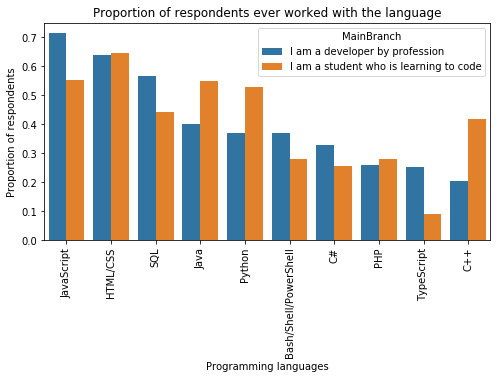

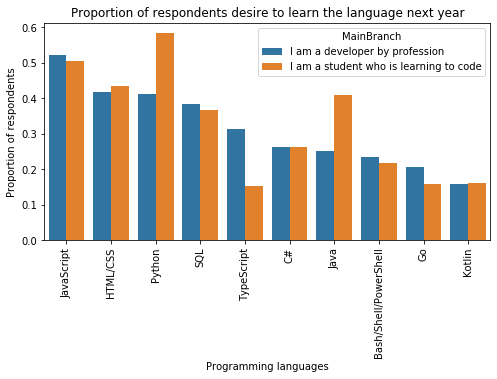

In [277]:
# Firstly check the most populous groups
print(df.MainBranch.value_counts()[:2])

#Second, groupby respondents based on their answer to the question of interest
for j in range(2):
    globals()['list_of_'+column_beginnings[j]]=[i for i in df.columns if column_beginnings[j] in i]
    globals()['df_'+column_beginnings[j]]= df.groupby(['MainBranch'], as_index=False)[globals()['list_of_'+column_beginnings[j]]].mean()
    globals()['df_'+column_beginnings[j]] = globals()['df_'+column_beginnings[j]][(globals()['df_'+column_beginnings[j]]['MainBranch'] == 'I am a developer by profession') | 
                       (globals()['df_'+column_beginnings[j]]['MainBranch'] == 'I am a student who is learning to code') ]
    globals()['df_'+column_beginnings[j]].columns=[i.replace(column_beginnings[j]+'_','') for i in globals()['df_'+column_beginnings[j]].columns]
    globals()['df_'+column_beginnings[j]]=globals()['df_'+column_beginnings[j]].set_index('MainBranch')
    globals()['df_'+column_beginnings[j]]=globals()['df_'+column_beginnings[j]].T
    globals()['df_'+column_beginnings[j]]=globals()['df_'+column_beginnings[j]].sort_values(by=['I am a developer by profession'], ascending=False)[:10]
    globals()['df_'+column_beginnings[j]]=globals()['df_'+column_beginnings[j]].reset_index()
    globals()['df_'+column_beginnings[j]] = pd.melt(globals()['df_'+column_beginnings[j]], id_vars='index', value_vars=['I am a developer by profession', 'I am a student who is learning to code'])
    
#Third, visualize the top 10 programming languages
for i in range(2):
    plt.figure(figsize=(8,4))
    globals()['chart'+str(i)]=sns.barplot(x='index', y='value', hue='MainBranch', data=globals()['df_'+column_beginnings[i]])
    globals()['chart'+str(i)].set_xticklabels(globals()['chart'+str(i)].get_xticklabels(), rotation=90)
    if i==0:
        plt.title('Proportion of respondents ever worked with the language')
        plt.ylabel('Proportion of respondents')
        plt.xlabel('Programming languages')
    else:
        plt.title('Proportion of respondents desire to learn the language next year')
        plt.ylabel('Proportion of respondents')
        plt.xlabel('Programming languages');

***

### Question 2: What factors explain career satisfaction?

Secondly, I was interested in finding out what factors contribute to developers' career satisfaction. Career satisfaction is a subjective measure provided on a 0-4 scale (after I transformed satisfaction categories to numeric). Applying a simple linear regression to find relationship between the variables may not be approporiate as the dependent variable (career satisfaction) can take on a limited set of discrete values. Therefore, in this analysis I test the performance of both OLS and multinomial logit to check which performs better in predicting career satisfaction based on the available factors. Not surprisingly, the latter performed better by more than 5% accuracy.

In [278]:
# Generate dictionary of categorical values to be transformed to numeric
to_numeric_columns={'EdLevel':{'I never completed any formal education':0,
                           'Primary/elementary school':1,
                           'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)':2,
                           'Some college/university study without earning a degree':3,
                           'Associate degree':4,
                           'Bachelor’s degree (BA, BS, B.Eng., etc.)':5,
                           'Master’s degree (MA, MS, M.Eng., MBA, etc.)':6,
                           'Professional degree (JD, MD, etc.)':7,
                           'Other doctoral degree (Ph.D, Ed.D., etc.)':8},
                'CareerSat':{'Very dissatisfied':0,
                            'Slightly dissatisfied':1,
                            'Neither satisfied nor dissatisfied':2,
                            'Slightly satisfied':3,
                            'Very satisfied':4},
                'SOVisitFreq':{'I have never visited Stack Overflow (before today)':0,
                              'Less than once per month or monthly':1,
                              'A few times per month or weekly':2,
                              'A few times per week':3,
                              'Daily or almost daily':4,
                              'Multiple times per day':5}}

# Perform cleaning
df2=dummy_numeric_generator(df, to_numeric_columns, dependent_var='CareerSat')

The following code outputs the accuracy measures of the two model. Because OLS predicts a float and logit an integer, it is not surprising that OLS manages to predict the correct integer only in 6.2% cases in the test set. Nonetheless, when rounding the OLS predictions to the nearest integer the results are more similar: OLS predicts correctly 34.4% of the values while logit 40% in the test data. This shows the advantage of using multinomial logit when we have count data as a dependent variable.

In [279]:
# Generate dependent and independent variable dataframes
x=df2.drop('CareerSat', axis=1)
y=df2['CareerSat']

# Use train-test split with a random state for reproducability
x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=0.3, random_state=2020)

# List the models to be used
models=['LinearRegression', 'LogisticRegression']
scores={}

# Instantiate, and fit the model on train set, the predict on test set
# Calculate the proprortion correctly predicted, and for OLS the accuracy when predictions are rounded
for i in models:
    globals()[i+'_model'] = globals()[i]() # Instantiate
    globals()[i+'_model'].fit(x_train, y_train) #Fit

    #Predict using model
    y_test_preds = globals()[i+'_model'].predict(x_test)
    y_train_preds = globals()[i+'_model'].predict(x_train)

    #Score using model
    scores[i+'_train'] = globals()[i+'_model'].score(x_train, y_train)
    scores[i+'_test'] = globals()[i+'_model'].score(x_test, y_test)
    
    if i=='LinearRegression':
        #Get accuracy for OLS with rounding
        scores[i+'_train_accuracy'] = accuracy_score(y_train, y_train_preds.round())
        scores[i+'_test_score'] = accuracy_score(y_test, y_test_preds.round())
        
pd.DataFrame(scores, index=['Scores']).T

Scores
LinearRegression_train           0.070462
LinearRegression_test            0.062493
LinearRegression_train_accuracy  0.345152
LinearRegression_test_score      0.343903
LogisticRegression_train         0.400631
LogisticRegression_test          0.400137

Furthermore, I was interested to see what are the most important factors that explain career satisfaction as presented by OLS. I used this model as the coefficients are more easily interpretable than with logit. We can see the 10 highest coefficients below: the opportunity to work remotely increases career satisfaction by around 0.5 point. Furthermore, being a manager also increases satisfaction while not having a job before and working in a toxic environment are the most negative factors. It is interesting to see that salary is not among the most important factors explaining career satisfaction.

In [280]:
#Obtain OLS coefficients and get the 10 largest in magnitude
coefficients = pd.concat([pd.DataFrame(x.columns),pd.DataFrame(np.transpose(LinearRegression_model.coef_))], axis = 1)
coefficients.columns=['Variable','Value']
coefficients=coefficients.reindex(coefficients['Value'].abs().sort_values(ascending=False).index)[:10]
coefficients

Variable     Value
148  WorkRemote_Less than half the time, but at lea...  0.513580
144                   WorkRemote_A few days each month  0.490809
146  WorkRemote_All or almost all the time (I'm ful...  0.490045
145                     WorkRemote_About half the time  0.425213
150   WorkRemote_More than half, but not all, the time  0.410924
149        WorkRemote_Less than once per month / Never  0.375124
133                  LastHireDate_I've never had a job -0.314065
137                     MgrWant_I am already a manager  0.286486
147                        WorkRemote_It's complicated  0.255361
55                WorkChallenge_Toxic work environment -0.233975

Finally, I wanted to check whether the coefficients are also significant statistically and the below table shows that they are indeed.

In [281]:
# Perform the same OLS analysis as above but now with statsmodel so that I obtain standard errors
x_train_constant = sm.add_constant(x_train)
ols = sm.OLS(y_train, x_train_constant)
ols_result = ols.fit()
ols_result=pd.DataFrame(ols_result.summary().tables[1])
ols_result.iloc[0]= ols_result.iloc[0].to_string().split('\n')
ols_result.columns = ols_result.iloc[0]
ols_result = ols_result[1:]
ols_result.columns=['variable', 'coef', 'std_err','t', 'P>|t|', '[0.025', '0.0975]']
ols_result['coef']=ols_result['coef'].astype(str).str.strip().astype(float)
ols_result = ols_result[ols_result['coef'].abs()>=0.23]
ols_result

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


variable    coef    std_err  \
1                                                const  2.3566      0.079   
57                WorkChallenge_Toxic work environment -0.2340      0.013   
135                  LastHireDate_I've never had a job -0.3141      0.092   
139                     MgrWant_I am already a manager  0.2865      0.032   
146                   WorkRemote_A few days each month  0.4908      0.041   
147                     WorkRemote_About half the time  0.4252      0.050   
148  WorkRemote_All or almost all the time (I'm ful...  0.4900      0.042   
149                        WorkRemote_It's complicated  0.2554      0.045   
150  WorkRemote_Less than half the time, but at lea...  0.5136      0.044   
151        WorkRemote_Less than once per month / Never  0.3751      0.041   
152   WorkRemote_More than half, but not all, the time  0.4109      0.048   

             t   P>|t|     [0.025    0.0975]  
1       30.018   0.000      2.203      2.510  
57     -17.341   0.000     -0.260     -0.208  
135     -3.396   0.001     -0.495     -0.133  
139      8.890   0.000      0.223      0.350  
146     11.828   0.000      0.409      0.572  
147      8.543   0.000      0.328      0.523  
148     11.665   0.000      0.408      0.572  
149      5.657   0.000      0.167      0.344  
150     11.742   0.000      0.428      0.599  
151      9.187   0.000      0.295      0.455  
152      8.495   0.000      0.316      0.506

***

### Question 3: Do transgender people have more pessimistic views about future?

My motivation to answer this question comes from a recent index.hu video in which transgender people were asked about their views on the newly proposed law that would prohibit Hungarians to change their gender at birth on papers. 3 out of the 4 transgender interviewees reported to work as a programmer as this profession is more open and accepting towards their gender identity. Therefore, using the dataset I would like to see whether transgender people are overrepresented in the survey (compared to their share in the overall population) and whether they differ significantly in any demographics from the non-transgender population.

Firstly, I checked the proportion of transgender people in the sample of respondents which is 1.15%. This is 90% higher than their overall share in the population which is around 0.6%. Therefore, this number clearly shows that transgender people are overrepresented in the developer profession.

In [282]:
# Prepare the dataset, now without adding any dependent variable to the dummy_numeric_generator function
df3=dummy_numeric_generator(df, to_numeric_columns)
# Generate list with first element number of non-trans, second number of trans people
trans_no_yes=list(df3['Trans_Yes'].value_counts())
# Obtain the proportion of trans in the sample
trans_proportion=trans_no_yes[1]/(trans_no_yes[0]+trans_no_yes[1])
print(trans_proportion)

0.011599518468098511


Secondly, I wanted to see whether transgender people differ in some background characteristics. From the data, we can conclude that non-trans respondents are better educated, more satisfied with their careers and visit the Stack Overflow site more frequently. Nonetheless, there are very little differences in the other background characteristics such as compensation, working hours and coding as a hobby.

In [283]:
# Groupby trans dummy variable and keep relevant numeric columns
df3.groupby(['Trans_Yes'])[['EdLevel', 'CareerSat', 'ConvertedComp', 'WorkWeekHrs', 'SOVisitFreq', 'BetterLife_Yes',
       'Age', 'Hobbyist_Yes']].mean()

EdLevel  CareerSat  ConvertedComp  WorkWeekHrs  SOVisitFreq  \
Trans_Yes                                                                 
0          4.671867   2.938912  127051.875820    42.127944     3.706427   
1          3.960726   2.736598  132126.448819    42.063622     2.977379   

           BetterLife_Yes        Age  Hobbyist_Yes  
Trans_Yes                                           
0                0.617926  30.354982      0.801336  
1                0.632396  28.778747      0.832202

Next, I was interested whether being a transgender person correlates strongly with some of the background variables. We can see that reporting non-binary gender is the most strongly correlated wit being trans, however, there is a weak correlation between believing that current generations have better life than their parents did (shown by the correlation of Trans_Yes and BetterLife_Yes columns). Therefore, it seems that transgender people are more optimist about where the world is heading than an average non-trans programmer.

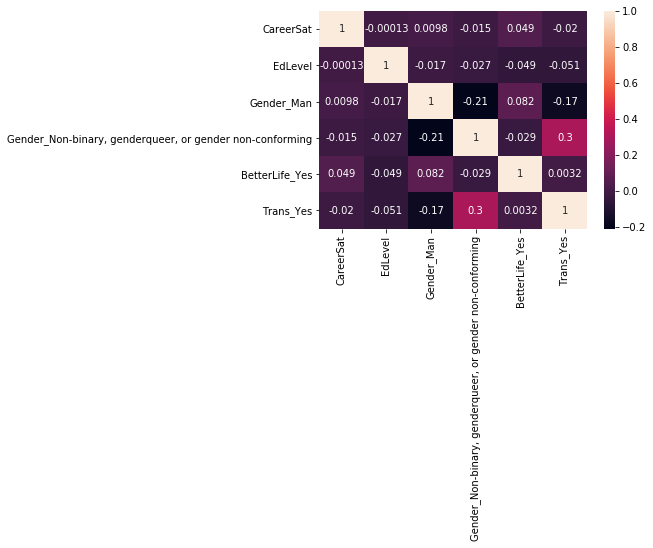

In [284]:
corrMatrix = df3[['CareerSat', 'EdLevel', 'Gender_Man', \
                  'Gender_Non-binary, genderqueer, or gender non-conforming', 'BetterLife_Yes', \
                  'Trans_Yes']].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

Finally, I wanted to see whether LGBT people have different aspirations about being a manager in the future and whether they take on different roles than non-LGBT programmers. For that, I first defined a category which indicates whether a respondent is a member of LGBT then visualized the categories of interest by LGBT membership. As can be seen from the bar charts, a larger proportion of LGBT respondents report themselves as students who learn programming, furthermore, they take on designer and system andministrator roles relatively more frequently. Secondly, LGBT people are less ambitious to take on leadership roles which is an interesting finding and should be further analysed to support equality of opportunity irrespective of gender and sexuality. 

In [285]:
def lgbt(dframe):
    if (dframe['Sexuality_Gay or Lesbian'] ==1) or (dframe['Sexuality_Bisexual'] == 1) or (dframe['Sexuality_Bisexual'] ==1):
        return 'Yes'
    elif (dframe['Sexuality_Straight / Heterosexual'] ==1):
        return 'No'
    else:
        return np.NaN

df3['LGBT']=df3.apply(lgbt, axis=1).dropna()
#df3['LGBT'].value_counts()

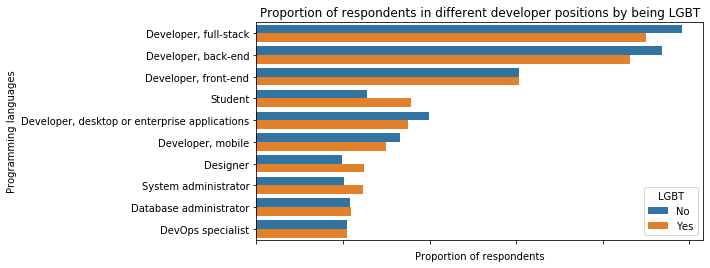

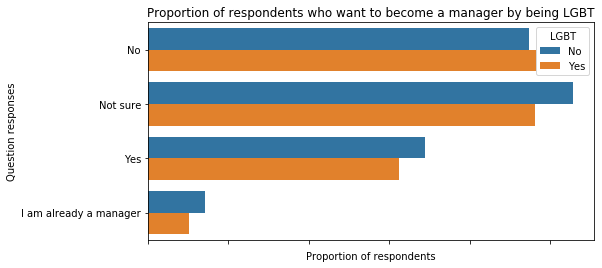

In [286]:
column_beginnings=['DevType', 'MgrWant']

for j in range(2):
    globals()['list_of_'+column_beginnings[j]]=[i for i in df2.columns if column_beginnings[j] in i]
    globals()['df_'+column_beginnings[j]]= df3.groupby(['LGBT'], as_index=False)[globals()['list_of_'+column_beginnings[j]]].mean()
    globals()['df_'+column_beginnings[j]].columns=[i.replace(column_beginnings[j]+'_','') for i in globals()['df_'+column_beginnings[j]].columns]
    globals()['df_'+column_beginnings[j]]=globals()['df_'+column_beginnings[j]].set_index('LGBT')
    globals()['df_'+column_beginnings[j]]=globals()['df_'+column_beginnings[j]].T
    globals()['df_'+column_beginnings[j]]=globals()['df_'+column_beginnings[j]].sort_values(by=['Yes'], ascending=False)[:10]
    globals()['df_'+column_beginnings[j]]=globals()['df_'+column_beginnings[j]].reset_index()
    globals()['df_'+column_beginnings[j]] = pd.melt(globals()['df_'+column_beginnings[j]], id_vars='index')
    
for i in range(2):
    plt.figure(figsize=(8,4))
    globals()['chart'+str(i)]=sns.barplot(x='value', y='index', hue='LGBT', data=globals()['df_'+column_beginnings[i]])
    globals()['chart'+str(i)].set_xticklabels(globals()['chart'+str(i)].get_xticklabels(), rotation=90)
    if i==0:
        plt.title('Proportion of respondents in different developer positions by being LGBT')
        plt.ylabel('Programming languages')
        plt.xlabel('Proportion of respondents')
    else:
        plt.title('Proportion of respondents who want to become a manager by being LGBT')
        plt.ylabel('Question responses')
        plt.xlabel('Proportion of respondents');

***
Appendix:

Questions corresponding to each column:

1. MainBranch - Which of the following options best describes you today? Here, by "developer" we mean "someone who writes code."
2. Hobbyist - Do you code as a hobby?
3. EdLevel - Which of the following best describes the highest level of formal education that you have completed?
4. UndergradMajor - What was your main or most important field of study?
5. EduOther - Which of the following types of non-degree education have you used or participated in? Please select all that apply.
6. DevType - Which of the following describe you? Please select all that apply.
7. CareerSat - Overall, how satisfied are you with your career thus far?
8. MgrWant - Do you want to become a manager yourself in the future?
9. LastHireDate - When was the last time that you took a job with a new employer?
10. JobFactors - Imagine that you are deciding between two job offers with the same compensation, benefits, and location. Of the following factors, which 3 are MOST important to you?
11. ConvertedComp - Salary converted to annual USD salaries using the exchange rate on 2019-02-01, assuming 12 working months and 50 working weeks.
12. WorkWeekHrs - On average, how many hours per week do you work?
13. WorkPlan - How structured or planned is your work?
14. WorkChallenge - Of these options, what are your greatest challenges to productivity as a developer? Select up to 3:
15. WorkRemote - How often do you work remotely?
16. LanguageWorkedWith - Which of the following programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year?  (If you both worked with the language and want to continue to do so, please check both boxes in that row.)
17. LanguageDesireNextYear - As above.
18. BetterLife - Do you think people born today will have a better life than their parents?
19. SOVisit1st - To the best of your memory, when did you first visit Stack Overflow?
20. SOVisitFreq - How frequently would you say you visit Stack Overflow?
21. Age - What is your age (in years)? If you prefer not to answer, you may leave this question blank.
22. Gender - Which of the following do you currently identify as? Please select all that apply. If you prefer not to answer, you may leave this question blank.
23. Trans - Do you identify as transgender?
24. Sexuality - Which of the following do you currently identify as? Please select all that apply. If you prefer not to answer, you may leave this question blank.